In [45]:
import os
import shutil
import matplotlib.pyplot as plt
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [69]:
dataset_path = './dataset/'
train_path = './images/train/'
test_path = './images/test/'
augmented_path = './images/augmented/'
WIDTH = 76
HEIGHT = 76

#### Divide images for training and testing

In [70]:
for folder in os.listdir(dataset_path):
    folder_path = os.path.join(dataset_path, folder)
    folder_train_path = os.path.join(train_path, folder)
    folder_test_path = os.path.join(test_path, folder)

    folder_images_count = len(os.listdir(folder_path))
    
    if folder not in os.listdir(train_path):
        os.mkdir(folder_train_path)
    if folder not in os.listdir(test_path):
        os.mkdir(folder_test_path)

    image_counter = 0
    train_threshold = folder_images_count * 0.8
    image_path = ''

    for image in os.listdir(folder_path):
        image_path = os.path.join(folder_path, image)
        resized_image = cv2.imread(image_path)

        if isinstance(resized_image, type(None)):
            continue

        resized_image = cv2.resize(resized_image, (WIDTH, HEIGHT))

        if image_counter <= train_threshold:
            cv2.imwrite(os.path.join(folder_train_path, image), resized_image)
            # shutil.copyfile(image_path, os.path.join(folder_train_path, image))
        else: 
            cv2.imwrite(os.path.join(folder_test_path, image), resized_image)
            # shutil.copyfile(image_path, os.path.join(folder_test_path, image))
        image_counter += 1


#### Data Augmentation

In [71]:
train_datagen = ImageDataGenerator(
							rescale = 1./255,
							rotation_range = 40,
							width_shift_range = 0.2,
							height_shift_range = 0.2,
							shear_range = 0.3,
							zoom_range = 0.3,
							horizontal_flip = True,)
							

Found 5495 images belonging to 11 classes.


<Figure size 432x288 with 0 Axes>

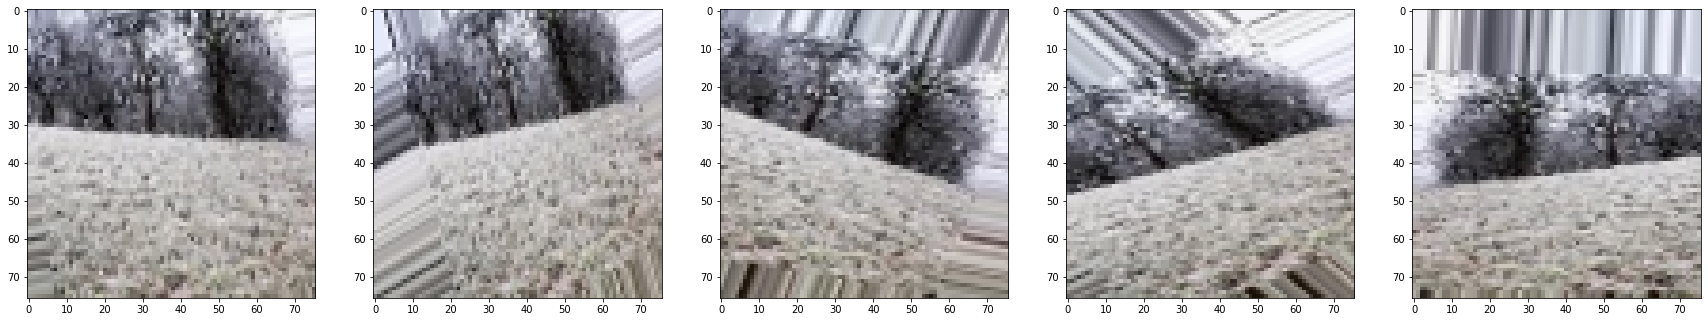

In [72]:
train_generator = train_datagen.flow_from_directory(
							train_path,
							target_size = (WIDTH, HEIGHT),
							batch_size = 1,
							class_mode ='binary',)


plt.figure()
#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(1, 5, figsize=(30, 8)) 

for i in range(5):
	axarr[i].imshow(train_generator[0][0][0])

Found 5495 images belonging to 11 classes.
(8, 76, 76, 3)
[5. 3. 8. 0. 7. 0. 3. 2.]


<Figure size 432x288 with 0 Axes>

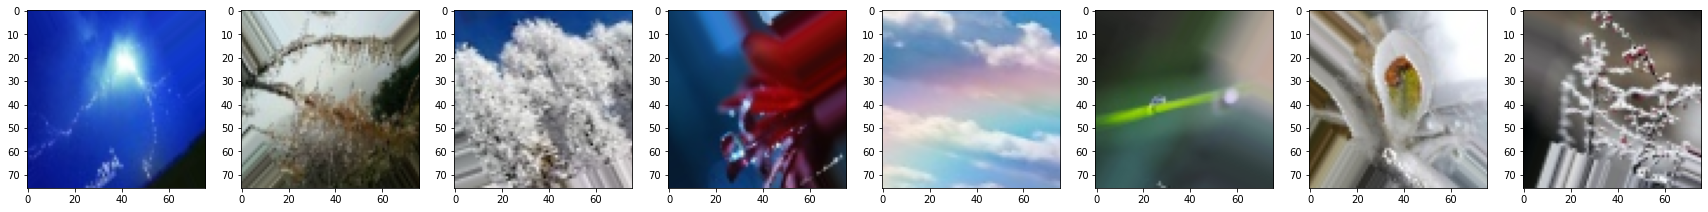

In [73]:
train_generator = train_datagen.flow_from_directory(
							train_path,
							target_size = (WIDTH, HEIGHT),
							batch_size = 8,
							class_mode ='binary',)

images , labels = train_generator[0]

print(images.shape)
print(labels)

plt.figure()
#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(1, images.shape[0], figsize=(30, 4)) 

for i in range(images.shape[0]):  
	axarr[i].imshow(images[i])

In [74]:
# Won't save augmented images
train_generator = train_datagen.flow_from_directory(
							train_path,
							target_size = (WIDTH, HEIGHT),
							batch_size = 8,
							class_mode ='binary',
							save_to_dir= augmented_path,   
                            save_prefix='aug',
                            save_format='png'
							)

Found 5495 images belonging to 11 classes.


#### Convolutional Neural Network

In [75]:
from tensorflow.keras import optimizers
from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential()
model.add(layers.Conv2D(5, (3, 3), activation="relu", input_shape = (WIDTH,HEIGHT,3)))
model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(1,activation='sigmoid'))

model.summary()

model.compile(loss='binary_crossentropy',
						optimizer=optimizers.RMSprop(learning_rate=2e-5),
						metrics=['acc'])


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 74, 74, 5)         140       
_________________________________________________________________
flatten_2 (Flatten)          (None, 27380)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               7009536   
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 257       
Total params: 7,009,933
Trainable params: 7,009,933
Non-trainable params: 0
_________________________________________________________________


Epoch 1/10
687/687 [==============================] - 86s 126ms/step - loss: -6228.0664 - acc: 0.1239
Epoch 2/10
687/687 [==============================] - 76s 111ms/step - loss: -17875.8223 - acc: 0.1239
Epoch 3/10
687/687 [==============================] - 78s 114ms/step - loss: -38240.9453 - acc: 0.1239
Epoch 4/10
687/687 [==============================] - 77s 112ms/step - loss: -71249.8047 - acc: 0.1239
Epoch 5/10
687/687 [==============================] - 84s 122ms/step - loss: -120572.8906 - acc: 0.12392s - loss: -11925
Epoch 6/10
687/687 [==============================] - 79s 115ms/step - loss: -190214.3750 - acc: 0.1239
Epoch 7/10
687/687 [==============================] - 74s 108ms/step - loss: -282049.3125 - acc: 0.12399s - loss: -273223.4375 - - ETA: 8s - loss: - - ETA: 5 - ETA: 1s - loss: -280663.1
Epoch 8/10
687/687 [==============================] - 72s 105ms/step - loss: -396789.8125 - acc: 0.1239
Epoch 9/10
687/687 [==============================] - 72s 104ms/step - los

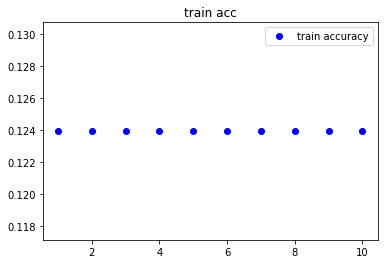

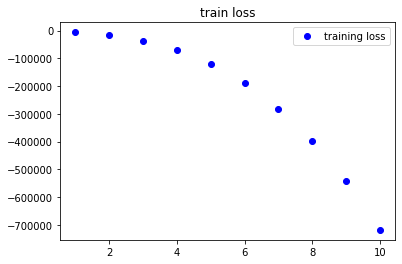

In [77]:
history = model.fit(train_generator, 
					epochs = 10)
			
acc = history.history['acc']
loss = history.history['loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'bo', label='train accuracy')
plt.title('train acc')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='training loss')
plt.title('train loss')
plt.legend()

plt.show()

In [80]:
print('There were ' + str(len(os.listdir(augmented_path))) + ' augmented images generated.')

There were 59277 augmented images generated.


Rafael Hinojosa López

A01705777

19 de mayo del 2023

TC2003B Actividad 2.2 Preprocesado de los datos